# Simple Iceberg Drift Model

An implementation of the model described in Turnball (2015).

### Equation of Motion

\begin{align}
M \frac{d \vec{V}}{dt} = \vec{F_a} + \vec{F_w} + \vec{F_c} + \vec{F_{wp}}
\end{align}

#### Air drag

\begin{align}
\vec{F_a} = (0.5 \rho_a C_a A_s + \rho_a C_{da} A_t ) \left| \vec{V_w} - \vec{V} \right| (\vec{V_w} - \vec{V})
\end{align}

#### Water drag

\begin{align}
\vec{F_w} = 
\end{align}

#### Coriolis

\begin{align}
\vec{F_c} &= 2 M \Omega \sin\phi \vec{k} \times \vec{V} \\
\end{align}

That is,

\begin{align}
\vec{F_c} / M &= (+f v, -fu, 0)
\end{align}

where $ f = 2\Omega \sin\phi $ is the Coriolis parameter.

#### Water pressure gradient

\begin{align}
\vec{F_{wp}} = M \left( \frac{d\vec{V_{wm}}}{dt}+  f \times \vec{V_{wm}} \right)
\end{align}

### Iceberg shapes

The shape
* Tabular
* Non-Tabular
* Domed
* Pinnacle
* Wedge
* Drydock
* Blocky

is used to modify the parametrization for the external forces.

In [13]:
class Iceberg():
    """
    Iceberg properties
    """
    name = "10-03"
      
    # shape
    shape = 'blocky'
    
    # scale factor (depends on shape)
    sf = 0.5   
    
    # size
    
    # Waterline length (m)
    L = 72
    
    # Maximum width (m)
    W = 72
    
    # Sail height (m)
    H = 22
    
    # Keel depth (m)
    
    # M = 7.12e3 * sf * L**2 * H
    
    # mass
    M_tons = 4.1e5 # metric tons
    M = M_tons * 1000  # kilograms
    
    # calculated properties
    
    # TODO: getters and setter
    # TODO: load/save iceberg data
    # TODO: visualize iceberg data
    
    

In [14]:
berg = Iceberg()

In [15]:
def coriolis_parameter(ϕ=50):
    """
    calculate the Coriolis parameter f
        f = 2 Ω sin(ϕ)
    for a given latitude ϕ in degrees North
    """
    Ω = 7.2921e-5 # rotation rate of earth in rad/s
    f = 2*Ω*np.sin(np.deg2rad(ϕ)) # calculate the Coriolis parameter
    
    return f

### Applied forces

In [16]:
def Fa(berg, Vx, Vy, t):
    """
    Calculate the air drag
    """
    
    # air velocity, "wind"
    Vax = 0*60.0*np.cos(1*np.pi*t/86400) # nominal value
    Vay = 0
    
    # calculate air density
    # TODO: effect of temperature and humidity
    ρa = 1.225 # kg/m^3
    
    Ca = 0.1
    As = 72 * 22 # (maximum width (m) * sail height (m))
    
    # TODO: add skin drag
    Fax = (0.5 * ρa * Ca * As) * abs(Vax - Vx) * (Vax - Vx)
    Fay = (0.5 * ρa * Ca * As) * abs(Vay - Vy) * (Vay - Vy)
    
    return Fax, Fay

In [17]:
def Fw(berg, Vx, Vy, t):
    """
    Calculate the water drag
    """
    Vcx = 0
    Vcy = 0
    
    ρw = 1027.5 # kg/m^3
    Cw = 2.5 #
    Ak = 7*110 # width (m) * keel depth (m)
    
    Cdw = 5.0e-4 #
    
    # TODO: extend to n-layer keel model
    # TODO: add skin drag
    Fwx = (0.5 * ρw * Cw * Ak *abs(Vcx - Vx)*(Vcx-Vx)) +(0)
    Fwy = (0.5 * ρw * Cw * Ak *abs(Vcy - Vy)*(Vcy-Vy)) +(0)
    
    return Fwx, Fwy

In [18]:
def Fc(berg, Vx, Vy, t):
    """
    Calculate the Coriolis force
    """
    f = coriolis_parameter()
    
    Fcx = + f * Vy * berg.M
    Fcy = - f * Vx * berg.M
    
    return Fcx, Fcy

In [67]:
def Fwp(berg, Vx, Vy, t):
    """
    Calculate the water pressure gradient
    """
    # Mean water current down to the iceberg keel
    Vwmx = 0
    Vwmy = 0
    
    # acceleration (time-derivative) of Vmw
    Amwx = 0
    Amwy = 0
    
    f = coriolis_parameter()
    
    Fwpx = berg.M*(Amwx + f*Vwmx)
    Fwpy = berg.M*(Amwy - f*Vwmy)
    
    return Fwpx, Fwpy

In [68]:
def calc_acceleration(berg, Vx, Vy, t):
    """
    """
    
    Fax, Fay = Fa(berg, Vx, Vy, t)
    Fcx, Fcy = Fc(berg, Vx, Vy, t)
    Fwx, Fwy = Fw(berg, Vx, Vy, t)
    Fwpx, Fwpy = Fwp(berg, Vx, Vy, t)
    
    # added mass
    Ma = 0.5*berg.M
                
    ax = (Fax + Fcx + Fwx + Fwpx) / (berg.M + Ma)
    ay = (Fay + Fcy + Fwy + Fwpy) / (berg.M + Ma)
    
    return ax, ay

In [69]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

### Numerical scheme

In [70]:
def solve(berg, dt=60.0):
    """
    Solve the equations of motion with
        dt time step in seconds
        
        berg is an Iceberg
    """
    tmax_hours = 72
    tmax = tmax_hours*60*60 # hours to seconds
    
    # total number of timesteps
    N = round(tmax/dt)

    # allocate memory for arrays
    x = np.zeros(N)
    y = np.zeros(N)
    vx = np.zeros(N)
    vy = np.zeros(N)
    ax = np.zeros(N)
    ay = np.zeros(N)
    t = np.zeros(N)

    # initial values
    x[0] = 0
    y[0] = 0
    vx[0] = 2
    vy[0] = 0
    ax[0], ay[0] = calc_acceleration(berg, vx[0], vy[0], t[0])
    t[0] = 0

    # integrate numerically
    for i in range(N-1):
        
        t[i+1] = t[i] + dt
            
        if i < 1:
            # explicit Euler forward scheme
            vx[i+1] = vx[i] + dt*ax[i]
            vy[i+1] = vy[i] + dt*ay[i]
        
            ax[i+1], ay[i+1] = calc_acceleration(berg, vx[i+1], vy[i+1], t[i+1])
        elif i < 3:
            # second order Adams Bashforth
            vx[i+1] = vx[i] + dt*(1.5*ax[i]-0.5*ax[i-1])
            vy[i+1] = vy[i] + dt*(1.5*ay[i]-0.5*ay[i-1])
            
            ax[i+1], ay[i+1] = calc_acceleration(berg, vx[i+1], vy[i+1], t[i+1])
        else:
            # fourth order Adams Bashforth, predictor-corrector
            vx[i+1] = vx[i] + dt/24*(55*ax[i]-59*ax[i-1]+37*ax[i-2]-9*ax[i-3])
            vy[i+1] = vy[i] + dt/24*(55*ay[i]-59*ay[i-1]+37*ay[i-2]-9*ay[i-3])    
            
            ax[i+1], ay[i+1] = calc_acceleration(berg, vx[i+1], vy[i+1], t[i+1])
            
            vx[i+1] = vx[i] + dt/24*(9*ax[i+1]+19*ax[i]-5*ax[i-1]+ax[i-2])
            vy[i+1] = vy[i] + dt/24*(9*ay[i+1]+19*ay[i]-5*ay[i-1]+ay[i-2])
            
            ax[i+1], ay[i+1] = calc_acceleration(berg, vx[i+1], vy[i+1], t[i+1])
            
        x[i+1] = x[i] + dt*vx[i+1]
        y[i+1] = y[i] + dt*vy[i+1]
  

        
        #print("{:8.1f} {:12.1f} {:12.1f} {:12.1f}".format(t[i+1], x[i+1], vx[i+1], ax[i+1]))
    
    return x, y, t

#### Plotting routine

In [71]:
def plot(x, y, label=''):
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.plot(x, y, label=label)

#### Driver

<IPython.core.display.Javascript object>


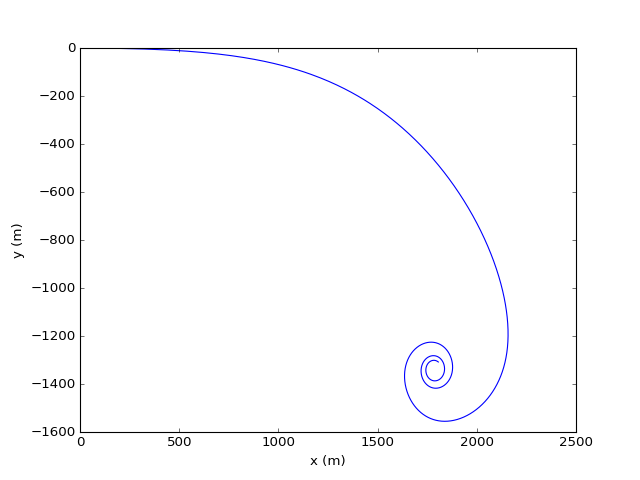

In [73]:

fig, axes = plt.subplots()

x, y, t = solve(berg)
plot(x,y, label='')
#plt.axis('equal')

In [75]:
import random
#random.gauss(0.07619,0.02)
random.gauss(0, 0.02)

-0.029881834243317154